## Classification of Irrigated/Rainfed In Madison Country using DecisionTreeClassifier

In this project, we are trying to solve the problem of classifying the fields as irrigated or rainfed using DecisionTreeClassifier.

### Libraries used:

1. Numpy
2. Pandas
3. Matplotlib for visualization and plotting


### The classification problem was solved following the steps given below:

1. Data Preprocessing and Cleaning 
2. Split data into 3 chunks using stratified sampling 
3. Apply decision tree algorithm 
4. Evaluation of Result 
5. Choose Best Model 


In [153]:
# Import libraries
%matplotlib inline

# Import python libraries
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

# Import data preprocessing algorithms implemented from scratch
from src.data_preprocessing.data_split import Stratify
from src.data_preprocessing.over_sample import SMOTE
from src.data_preprocessing.pca import PCA
from src.data_preprocessing.standardize import Standardize

# Implementation of decision tree algorithm and pruning
from src.decision_tree.decision_tree import DecisionTree
from src.decision_tree.pruning import *

# Evaluation metric for test set
from src.evaluation.evaluation import Metrics

In [154]:
## Read dataset
df_1 = pd.read_excel(r'data/Madison_Irrigated_2.xls')
df_2 = pd.read_excel(r'data/Madison_Rainfed_2.xls')

### Data Preprocessing and Cleaning:
The following steps were carried out for data preprocessing and cleaning:

i. Missing values were handled using linear interpolation.

ii. As the dataset was imbalanced (containing {1: 1288, 0: 5053}), it was handled using an oversampling algorithm: Smote.

iii. The data was standardized using z-score normalization.

iv. PCA was used for dimensionality reduction. (As using principal components with more than 95% resulted in overfitting from even a small decision tree, 91% variance were preserved while performing the dimensionality reduction with only 10 principal components.)


In [155]:
## Remove unnecessary column
df_concat = pd.concat([df_1, df_2], ignore_index=True)
df_concat.drop(['Unnamed: 0'], axis=1, inplace=True)

In [156]:
## Handle missing values using linear interpolation
df_interpolate=df_concat.interpolate(ignore_index=True)

In [157]:
## Divide into feature and target set
X = df_interpolate.loc[ : , df_interpolate.columns != 'Irr_Rf']
y = df_interpolate['Irr_Rf']

Text(0.5, 1.0, 'Data Distribution')

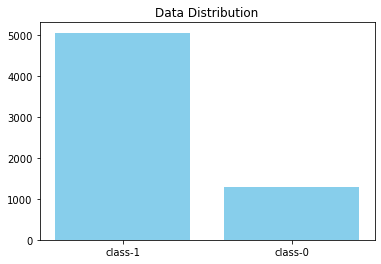

In [158]:
# Imbalanced data set
unique, counts = np.unique(y, return_counts=True)
y_count = dict(zip(unique, counts))
plt.bar(y_count.keys(), y_count.values(), color="skyblue", tick_label =['class-1','class-0'])
plt.title('Data Distribution')

### Handle skewness

In [159]:
# Oversample data
sm = SMOTE(dims=20)
X_res, y_res = sm.fit_transform(X.values,y.values)

Text(0.5, 1.0, 'Data Distribution')

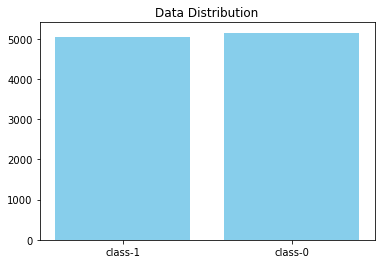

In [160]:
# Data distribution after applying oversampling using smote algorithm
unique, counts = np.unique(y_res, return_counts=True)
y_count = dict(zip(unique, counts))
plt.bar(y_count.keys(), y_count.values(), color="skyblue", tick_label =['class-1','class-0'])
plt.title('Data Distribution')

### Standardize

In [161]:
# Standardize data using z-score
X_scaled = Standardize(X_res).compute_z_score()

### Dimensionality reduction using PCA

In [162]:
# Apply PCA preserving 91 % of the total variance
X_reduced = PCA(num_components=10).fit_transform(X_scaled)

### Preprocessed Dataframe

In [163]:
# Dataframe containing the standardized data with its 14 principal components
df_preprocessed = pd.DataFrame(X_reduced, columns=['PC1', 'PC2', 'PC3', 'PC4', 'PC5', 'PC6', 'PC7', 'PC8', 'PC9','PC10'])
df_preprocessed['label'] = y_res

In [164]:
#Shuffle preprocessed dataframe
df_shuffled = df_preprocessed.sample(frac=1)
df_shuffled.head()

,PC1,PC2,PC3,PC4,PC5,PC6,PC7,PC8,PC9,PC10,label
985,1.012212,1.739627,0.671250,1.717268,-1.195310,-0.552448,-0.460476,-0.558824,0.591402,0.290559,1.0
1972,1.457566,-1.327848,-2.448034,0.835685,-0.408885,-0.038564,-0.314966,-0.578595,-0.042447,-0.349294,0.0
1571,0.390096,0.682780,2.228233,0.658302,-2.042057,0.263625,-0.442621,-0.185140,-0.372645,0.390852,0.0
4896,1.538844,0.764307,2.978357,-1.954084,-1.289391,-0.382898,-0.305856,-0.334378,0.124933,-0.074096,0.0
1898,0.816865,0.284322,0.625427,0.298636,-0.612187,-0.020626,-0.069631,-0.907903,0.173454,0.304326,0.0


### Split into train, validation and test set

After data preprocessing and cleaning, the data were splitted into three chunks: train, validation and test containing 70%, 20% and 10% of total data respectively using stratified sampling. Thereafter, the data were shuffled in each of these sets.


In [165]:
# Add 10% of shuffled data to test set
df_train, df_test = Stratify(df_shuffled, 'label', 0.1).train_test_split()

In [166]:
# Add 20% of shuffled data to val set and remaining (80%) to train set
df_train, df_val = Stratify(df_shuffled, 'label', 0.2).train_test_split()

### Apply decision tree algorithm

In [15]:
acc_train = []
acc_test = []
acc_val = []
i_values = []

In [16]:
import time
print("Decision Tree - Irrigated/Rainfed In Madison Country")
i = 1
accuracy_train = 0
while accuracy_train < 100:
    start_time = time.time()
    # Initialize decision tree
    tree = DecisionTree(max_depth = i)
    # Build the tree
    decision_tree = tree.build_decision_tree(df_train)
    building_time = time.time() - start_time
    decision_tree_val_results = tree.predictions(df_val, decision_tree)
    decision_tree_test_results = tree.predictions(df_test, decision_tree)
    accuracy_val = tree.calculate_accuracy(decision_tree_val_results, df_val.iloc[:, -1]) * 100
    accuracy_test = tree.calculate_accuracy(decision_tree_test_results, df_test.iloc[:, -1]) * 100
    decision_tree_train_results = tree.predictions(df_train, decision_tree) 
    accuracy_train = tree.calculate_accuracy(decision_tree_train_results, df_train.iloc[:, -1]) * 100
    print("maxDepth = {}: ".format(i), end = "")
    print("accTest = {0:.2f}%, ".format(accuracy_test), end = "")
    print("accTrain = {0:.2f}%, ".format(accuracy_train), end = "")
    print("accVal = {0:.2f}%, ".format(accuracy_val), end = "")
    print("buildTime = {0:.2f}s".format(building_time), end = "\n")
    acc_train.append(accuracy_train)
    acc_val.append(accuracy_val)
    acc_test.append(accuracy_test)
    i_values.append(i)
    i += 1

Decision Tree - Irrigated/Rainfed In Madison Country
maxDepth = 1: accTest = 64.12%, accTrain = 63.92%, accVal = 64.80%, buildTime = 52.23s
maxDepth = 2: accTest = 67.65%, accTrain = 67.52%, accVal = 66.47%, buildTime = 84.71s
maxDepth = 3: accTest = 71.18%, accTrain = 70.92%, accVal = 70.25%, buildTime = 115.92s
maxDepth = 4: accTest = 71.86%, accTrain = 71.76%, accVal = 71.32%, buildTime = 144.28s
maxDepth = 5: accTest = 73.24%, accTrain = 73.77%, accVal = 71.96%, buildTime = 161.45s
maxDepth = 6: accTest = 77.16%, accTrain = 76.29%, accVal = 73.58%, buildTime = 174.01s
maxDepth = 7: accTest = 77.75%, accTrain = 78.48%, accVal = 74.61%, buildTime = 185.51s
maxDepth = 8: accTest = 79.31%, accTrain = 80.67%, accVal = 76.32%, buildTime = 193.40s
maxDepth = 9: accTest = 80.98%, accTrain = 83.11%, accVal = 76.86%, buildTime = 202.21s
maxDepth = 10: accTest = 83.43%, accTrain = 85.76%, accVal = 78.87%, buildTime = 204.03s
maxDepth = 11: accTest = 85.98%, accTrain = 88.90%, accVal = 80.88%,

### Plot train and validation set accuracy and error graph

In [24]:
error_train = 1 - (np.array(acc_train)/100)
error_val = 1 - (np.array(acc_val)/100)
error_test = 1 - (np.array(acc_test)/100)

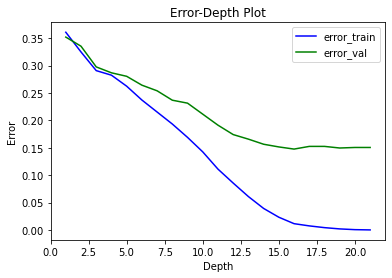

In [34]:
# Plotting the Graph
plt.plot(i_values, error_train, "-b", label="error_train")
plt.plot(i_values, error_val, "-g", label="error_val")
plt.title("Error-Depth Plot")
plt.xlabel("Depth")
plt.ylabel("Error")
plt.legend()
plt.show()

In [31]:
acc_train = np.array(acc_train)/100
acc_val = np.array(acc_val)/100
acc_test = np.array(acc_test)/100

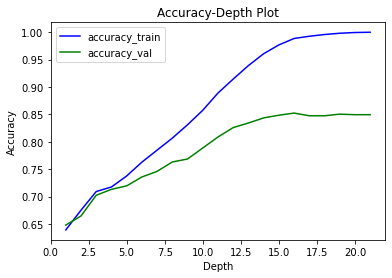

In [35]:
# Plotting the Graph
plt.plot(i_values, acc_train, "-b", label="accuracy_train")
plt.plot(i_values, acc_val, "-g", label="accuracy_val")
plt.title("Accuracy-Depth Plot")
plt.xlabel("Depth")
plt.ylabel("Accuracy")
plt.legend()
plt.show()

### Plot decision boundary

In [138]:
X_train = df_train.values
y_train = df_train['label'].values

In [ ]:
from itertools import product

# Loading data
X = X_train[:,:2]
y= y_train

In [ ]:
# Training decision trees
clf5 = DecisionTree(max_depth=5)
clf6 = DecisionTree(max_depth=6)
clf7 = DecisionTree(max_depth=7)
clf8 = DecisionTree(max_depth=8)
clf9 = DecisionTree(max_depth=9)
clf10 = DecisionTree(max_depth=10)
clf11 = DecisionTree(max_depth=11)
clf12 = DecisionTree(max_depth=12)

c5 = clf5.build_decision_tree(df_train)
c6 = clf6.build_decision_tree(df_train)
c7 = clf7.build_decision_tree(df_train)
c8 = clf8.build_decision_tree(df_train)
c9 = clf9.build_decision_tree(df_train)
c10 = clf10.build_decision_tree(df_train)
c11 = clf11.build_decision_tree(df_train)
c12 = clf12.build_decision_tree(df_train)

### Decision Boundary on Training dataset

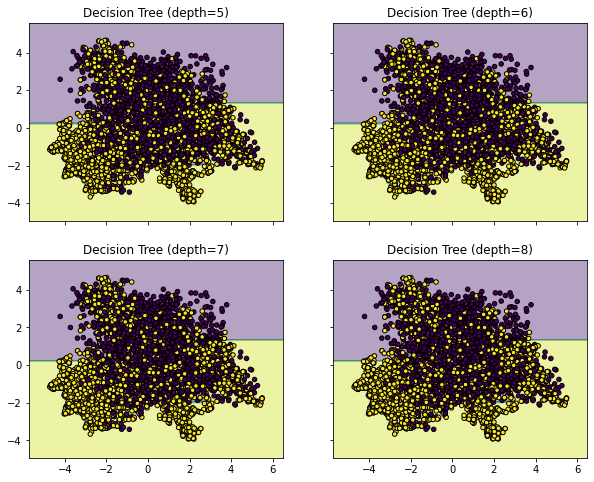

In [45]:
# Plotting decision boundaries for training set (depth- 5,6,7,8)
x_min, x_max = X[:, 0].min() - 1, X[:, 0].max() + 1
y_min, y_max = X[:, 1].min() - 1, X[:, 1].max() + 1
xx, yy = np.meshgrid(np.arange(x_min, x_max, 0.1),
                     np.arange(y_min, y_max, 0.1))

f, axarr = plt.subplots(2, 2, sharex='col', sharey='row', figsize=(10, 8))

for idx, clf, tt, c in zip(product([0, 1], [0, 1]),
                        [clf5, clf6, clf7, clf8],
                        ['Decision Tree (depth=5)','Decision Tree (depth=6)','Decision Tree (depth=7)','Decision Tree (depth=8)'],[c5,c6,c7,c8]):

    Z = clf.predictions(pd.DataFrame(np.c_[xx.ravel(), yy.ravel(),np.zeros(13038),np.zeros(13038),np.zeros(13038),np.zeros(13038),np.zeros(13038),np.zeros(13038),np.zeros(13038),np.zeros(13038)], columns=['PC1', 'PC2', 'PC3', 'PC4', 'PC5', 'PC6', 'PC7', 'PC8', 'PC9','PC10']), c).values
    Z = Z.reshape(xx.shape)

    axarr[idx[0], idx[1]].contourf(xx, yy, Z, alpha=0.4)
    axarr[idx[0], idx[1]].scatter(X[:, 0], X[:, 1], c=y,
                                  s=20, edgecolor='k')
    axarr[idx[0], idx[1]].set_title(tt)

plt.show()

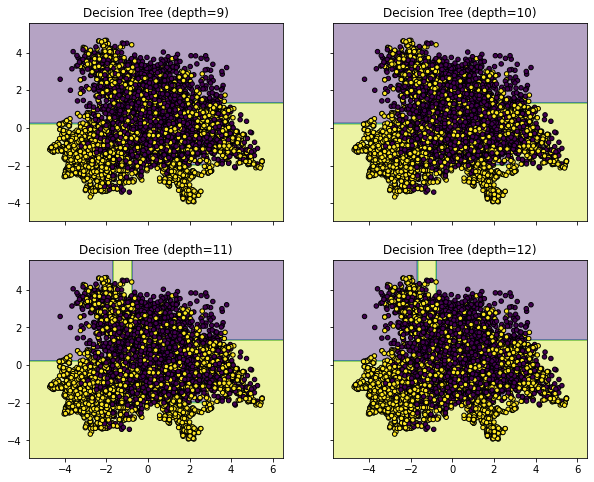

In [46]:
# Plotting decision boundaries for training set (depth - 9,10,11,12)
f, axarr = plt.subplots(2, 2, sharex='col', sharey='row', figsize=(10, 8))

for idx, clf, tt, c in zip(product([0, 1], [0, 1]),
                        [clf9, clf10, clf11, clf12],
                        ['Decision Tree (depth=9)','Decision Tree (depth=10)','Decision Tree (depth=11)','Decision Tree (depth=12)'],[c9,c10,c11,c12]):

    Z = clf.predictions(pd.DataFrame(np.c_[xx.ravel(), yy.ravel(),np.zeros(13038),np.zeros(13038),np.zeros(13038),np.zeros(13038),np.zeros(13038),np.zeros(13038),np.zeros(13038),np.zeros(13038)], columns=['PC1', 'PC2', 'PC3', 'PC4', 'PC5', 'PC6', 'PC7', 'PC8', 'PC9','PC10']), c).values
    Z = Z.reshape(xx.shape)

    axarr[idx[0], idx[1]].contourf(xx, yy, Z, alpha=0.4)
    axarr[idx[0], idx[1]].scatter(X[:, 0], X[:, 1], c=y,
                                  s=20, edgecolor='k')
    axarr[idx[0], idx[1]].set_title(tt)

plt.show()

### Decision Boundary on Validation dataset

In [56]:
X_val = df_val.values
y_val = df_val['label'].values

X = X_val[:,:2]
y= y_val

x_min, x_max = X[:, 0].min() - 1, X[:, 0].max() + 1
y_min, y_max = X[:, 1].min() - 1, X[:, 1].max() + 1
xx, yy = np.meshgrid(np.arange(x_min, x_max, 0.1),
                     np.arange(y_min, y_max, 0.1))

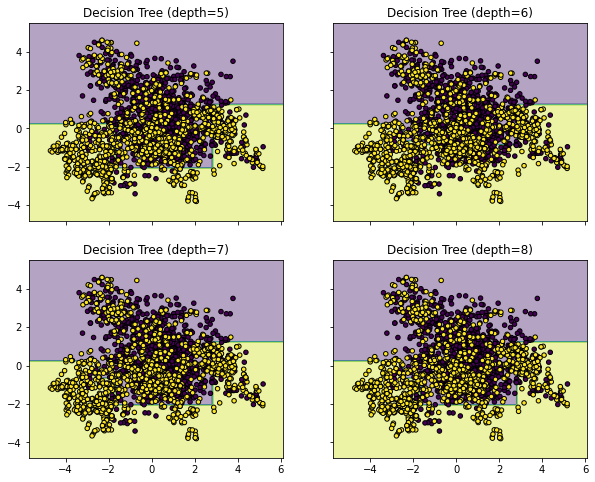

In [49]:
# Plotting decision boundaries for validation set (depth- 5,6,7,8)
f, axarr = plt.subplots(2, 2, sharex='col', sharey='row', figsize=(10, 8))

for idx, clf, tt, c in zip(product([0, 1], [0, 1]),
                        [clf5, clf6, clf7, clf8],
                        ['Decision Tree (depth=5)','Decision Tree (depth=6)','Decision Tree (depth=7)','Decision Tree (depth=8)'],[c5,c6,c7,c8]):

    Z = clf.predictions(pd.DataFrame(np.c_[xx.ravel(), yy.ravel(),np.zeros(12376),np.zeros(12376),np.zeros(12376),np.zeros(12376),np.zeros(12376),np.zeros(12376),np.zeros(12376),np.zeros(12376)], columns=['PC1', 'PC2', 'PC3', 'PC4', 'PC5', 'PC6', 'PC7', 'PC8', 'PC9','PC10']), c).values
    Z = Z.reshape(xx.shape)

    axarr[idx[0], idx[1]].contourf(xx, yy, Z, alpha=0.4)
    axarr[idx[0], idx[1]].scatter(X[:, 0], X[:, 1], c=y,
                                  s=20, edgecolor='k')
    axarr[idx[0], idx[1]].set_title(tt)

plt.show()

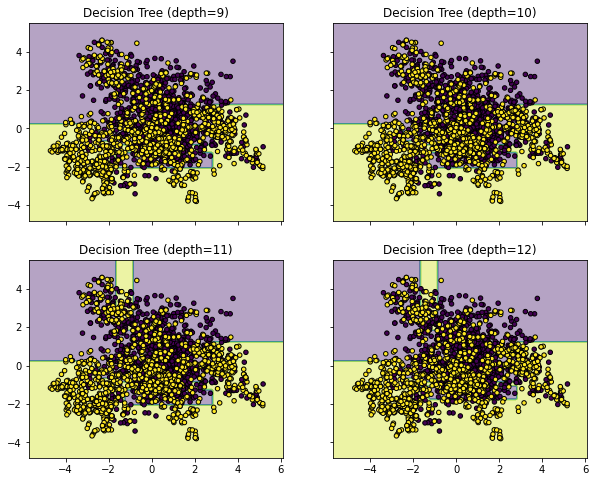

In [58]:
# Plotting decision boundaries for validation set (depth - 9,10,11,12)
f, axarr = plt.subplots(2, 2, sharex='col', sharey='row', figsize=(10, 8))

for idx, clf, tt, c in zip(product([0, 1], [0, 1]),
                        [clf9, clf10, clf11, clf12],
                        ['Decision Tree (depth=9)','Decision Tree (depth=10)','Decision Tree (depth=11)','Decision Tree (depth=12)'],[c9,c10,c11,c12]):

    Z = clf.predictions(pd.DataFrame(np.c_[xx.ravel(), yy.ravel(),np.zeros(12376),np.zeros(12376),np.zeros(12376),np.zeros(12376),np.zeros(12376),np.zeros(12376),np.zeros(12376),np.zeros(12376)], columns=['PC1', 'PC2', 'PC3', 'PC4', 'PC5', 'PC6', 'PC7', 'PC8', 'PC9','PC10']), c).values
    Z = Z.reshape(xx.shape)

    axarr[idx[0], idx[1]].contourf(xx, yy, Z, alpha=0.4)
    axarr[idx[0], idx[1]].scatter(X[:, 0], X[:, 1], c=y,
                                  s=20, edgecolor='k')
    axarr[idx[0], idx[1]].set_title(tt)

plt.show()

### Pruning the decision tree

In [125]:
c11

{'PC1 <= -1.6890073840972817': [{'PC2 <= 0.25506197863442126': [{'PC7 <= 0.3157961384451811': [{'PC2 <= -0.6694409835214316': [{'PC6 <= 1.47639509178355': [{'PC2 <= -1.3503830313073504': [{'PC5 <= -0.7079383924365696': [{'PC9 <= -0.1948381122947323': [0.0,
                1.0]},
              1.0]},
            {'PC4 <= -1.0233661398387637': [1.0,
              {'PC4 <= -0.9739694629062025': [0.0,
                {'PC1 <= -2.622189387152011': [{'PC2 <= -1.3453939343458021': [0.0,
                    1.0]},
                  {'PC5 <= 1.0010424861066107': [{'PC5 <= 0.34262767481838874': [1.0,
                      0.0]},
                    1.0]}]}]}]}]},
          0.0]},
        {'PC1 <= -2.4647966570768807': [{'PC6 <= -1.3072502093879264': [0.0,
            {'PC2 <= -0.6682755550436679': [0.0,
              {'PC10 <= -0.46837880122242437': [{'PC7 <= -0.14886595619428344': [0.0,
                  1.0]},
                {'PC5 <= -1.2338154359449642': [{'PC10 <= 0.21899263510303463': [1.0

In [126]:
tree_pruned = post_pruning(clf11, c11, df_train, df_val)
tree_pruned

{'PC1 <= -1.6890073840972817': [{'PC2 <= 0.25506197863442126': [{'PC7 <= 0.3157961384451811': [{'PC2 <= -0.6694409835214316': [{'PC6 <= 1.47639509178355': [{'PC2 <= -1.3503830313073504': [1.0,
            {'PC4 <= -1.0233661398387637': [1.0,
              {'PC4 <= -0.9739694629062025': [0.0, 1.0]}]}]},
          0.0]},
        {'PC1 <= -2.4647966570768807': [1.0,
          {'PC3 <= -1.407994624123976': [1.0, 0.0]}]}]},
      {'PC2 <= -1.943909363913789': [{'PC10 <= 0.11807250404825198': [1.0,
          0.0]},
        {'PC1 <= -2.8882985891337065': [1.0,
          {'PC4 <= -0.033545102164841155': [{'PC4 <= -1.2143539776611834': [1.0,
              {'PC7 <= 0.9078491276284778': [{'PC9 <= 0.46349101071831744': [0.0,
                  {'PC9 <= 0.6462938574997463': [1.0, 0.0]}]},
                0.0]}]},
            {'PC5 <= 0.9003449274082487': [{'PC6 <= 0.26909854475861417': [{'PC8 <= 0.004433162810103225': [1.0,
                  0.0]},
                1.0]},
              0.0]}]}]}]}]},

### Effect of pruning on training dataset

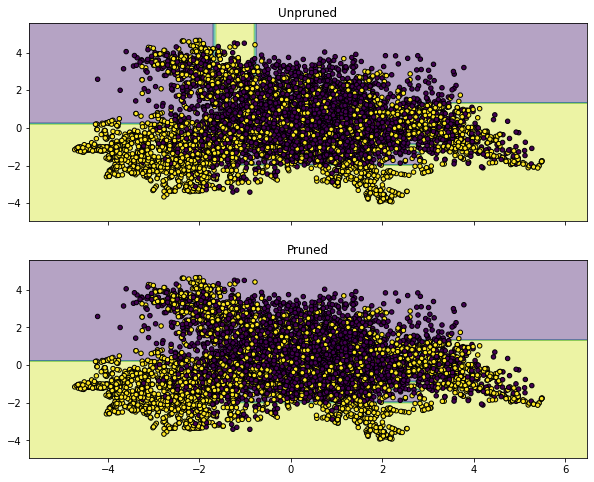

In [127]:
# Loading training data
X = X_train[:,:2]
y= y_train

# Plotting decision regions
x_min, x_max = X[:, 0].min() - 1, X[:, 0].max() + 1
y_min, y_max = X[:, 1].min() - 1, X[:, 1].max() + 1
xx, yy = np.meshgrid(np.arange(x_min, x_max, 0.1),
                     np.arange(y_min, y_max, 0.1))

f, axarr = plt.subplots(2, 1, sharex='col', sharey='row', figsize=(10, 8))

for idx, clf, tt, c in zip(range(0, 2),
                        [clf11, clf11],
                        ['Unpruned','Pruned'],[c11,tree_pruned]):

    Z = clf.predictions(pd.DataFrame(np.c_[xx.ravel(), yy.ravel(),np.zeros(13038),np.zeros(13038),np.zeros(13038),np.zeros(13038),np.zeros(13038),np.zeros(13038),np.zeros(13038),np.zeros(13038)], columns=['PC1', 'PC2', 'PC3', 'PC4', 'PC5', 'PC6', 'PC7', 'PC8', 'PC9','PC10']), c).values
    Z = Z.reshape(xx.shape)

    axarr[idx].contourf(xx, yy, Z, alpha=0.4)
    axarr[idx].scatter(X[:, 0], X[:, 1], c=y,
                                  s=20, edgecolor='k')
    axarr[idx].set_title(tt)

plt.show()

### Effect of pruning on validation dataset

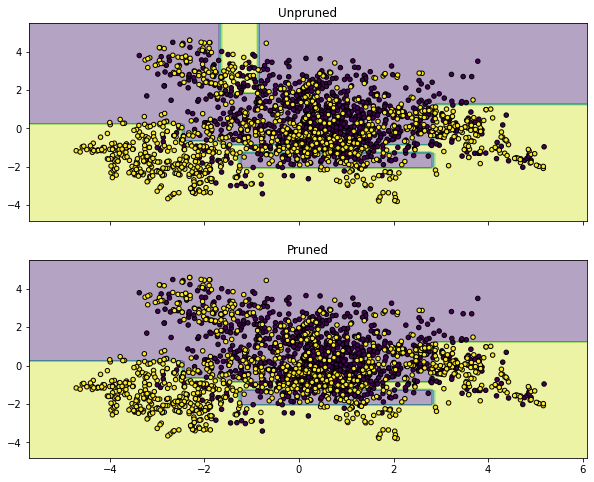

In [128]:
# Loading validation data
X = X_val[:,:2]
y= y_val

# Plotting decision regions
x_min, x_max = X[:, 0].min() - 1, X[:, 0].max() + 1
y_min, y_max = X[:, 1].min() - 1, X[:, 1].max() + 1
xx, yy = np.meshgrid(np.arange(x_min, x_max, 0.1),
                     np.arange(y_min, y_max, 0.1))

f, axarr = plt.subplots(2, 1, sharex='col', sharey='row', figsize=(10, 8))

for idx, clf, tt, c in zip(range(0, 2),
                        [clf11, clf11],
                        ['Unpruned','Pruned'],[c11,tree_pruned]):

    Z = clf.predictions(pd.DataFrame(np.c_[xx.ravel(), yy.ravel(),np.zeros(12376),np.zeros(12376),np.zeros(12376),np.zeros(12376),np.zeros(12376),np.zeros(12376),np.zeros(12376),np.zeros(12376)], columns=['PC1', 'PC2', 'PC3', 'PC4', 'PC5', 'PC6', 'PC7', 'PC8', 'PC9','PC10']), c).values
    Z = Z.reshape(xx.shape)

    axarr[idx].contourf(xx, yy, Z, alpha=0.4)
    axarr[idx].scatter(X[:, 0], X[:, 1], c=y,
                                  s=20, edgecolor='k')
    axarr[idx].set_title(tt)

plt.show()

### Evaluation of pruned and unpruned model on test dataset

In [114]:
clf11 = DecisionTree(max_depth=11)
c11 = clf11.build_decision_tree(df_train)

In [132]:
pred_c11 = clf11.predictions(df_test, c11)
print(Metrics(df_test['label'], pred_c11).confusion_matrix())
Metrics(df_test['label'], pred_c11).report()

[[442  68]
 [ 75 435]]
Accuracy: 0.86
Precision (1): 0.86
Precision (0): 0.85
Recall (1): 0.85
Recall (0): 0.87
F1-score (1): 0.86
F1-score (0): 0.86


In [133]:
pred_pruned = clf11.predictions(df_test, tree_pruned)
print(Metrics(df_test['label'], pred_pruned).confusion_matrix())
Metrics(df_test['label'], pred_pruned).report()

[[443  67]
 [ 95 415]]
Accuracy: 0.84
Precision (1): 0.86
Precision (0): 0.82
Recall (1): 0.81
Recall (0): 0.87
F1-score (1): 0.84
F1-score (0): 0.85


### Result of different models on test dataset

In [134]:
pred_c5 = clf5.predictions(df_test, c5)
print(Metrics(df_test['label'], pred_c5).confusion_matrix())
Metrics(df_test['label'], pred_c5).report()

[[421  89]
 [184 326]]
Accuracy: 0.73
Precision (1): 0.79
Precision (0): 0.7
Recall (1): 0.64
Recall (0): 0.83
F1-score (1): 0.7
F1-score (0): 0.76


In [135]:
pred_c6 = clf6.predictions(df_test, c6)
print(Metrics(df_test['label'], pred_c6).confusion_matrix())
Metrics(df_test['label'], pred_c6).report()

[[446  64]
 [169 341]]
Accuracy: 0.77
Precision (1): 0.84
Precision (0): 0.73
Recall (1): 0.67
Recall (0): 0.87
F1-score (1): 0.75
F1-score (0): 0.79


In [137]:
pred_c21 = clf21.predictions(df_test, c21)
print(Metrics(df_test['label'], pred_c21).confusion_matrix())
Metrics(df_test['label'], pred_c21).report()

[[494  16]
 [  9 501]]
Accuracy: 0.98
Precision (1): 0.97
Precision (0): 0.98
Recall (1): 0.98
Recall (0): 0.97
F1-score (1): 0.98
F1-score (0): 0.98


### Conclusion:

Hence, the data was first pre-processed and cleaned, standardized and pca was applied. After training with the decision tree classifier, we plotted the graph and found that there was a wide gap between training and validation accuracy. Thus, there was an overfitting. To handle that, we pruned the decision tree, and evaluated the result on a test (unseen) dataset.
